In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
# 1. 이미지 경로 및 레이블 리스트 생성
base_dir_original = 'Training'  # 데이터가 저장된 기본 경로
image_paths = []
labels = []

for folder_name in os.listdir(base_dir_original):
    folder_path = os.path.join(base_dir_original, folder_name)
    if os.path.isdir(folder_path):
        # 레이블 추출: 폴더 이름에서 정보 파싱
        label = folder_name.split(']')[-1].split('_')[0]
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_path.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                labels.append(label)
unique_labels = sorted(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
labels = [label_to_index[label] for label in labels]

# train-test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42
)

# 3. 이미지 로드 및 전처리 함수 정의
def preprocess_image(image_path, label, target_height=128, target_width=128):
    # 이미지 읽기
    image = tf.io.read_file(image_path)
    # 이미지 디코딩 및 리사이징
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, target_height, target_width)
    # 픽셀 값을 0~1로 정규화
    image = image / 255.0
    return image, label

# 4. TensorFlow 데이터 파이프라인 생성
def create_dataset(image_paths, labels, batch_size=32, target_height=128, target_width=128):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    # 데이터셋 전처리 매핑
    dataset = dataset.map(lambda path, label: preprocess_image(path, label, target_height, target_width),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # 데이터 셔플 및 배치
    dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


# 5. 학습 및 테스트 데이터셋 생성
batch_size = 32
train_dataset = create_dataset(train_paths, train_labels, batch_size)
test_dataset = create_dataset(test_paths, test_labels, batch_size)

2024-12-07 12:01:29.554266: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 12:01:29.796045: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-12-07 12:01:31.699399: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 12:01:31.864808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46382 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:65:00.0, compute capability: 8.0


In [2]:


import tensorflow as tf

model12 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    
    # 첫 번째 Convolutional Layer
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),  # 첫 번째 풀링 레이어 이후 드롭아웃

    # 두 번째 Convolutional Layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),  # 두 번째 풀링 레이어 이후 드롭아웃

    # 세 번째 Convolutional Layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),  # 세 번째 풀링 레이어 이후 드롭아웃

    # 네 번째 Convolutional Layer
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),

    # 첫 번째 Fully Connected Layer
    tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # 정규화
    tf.keras.layers.Dropout(0.5),  # 마지막 드롭아웃

    # Output Layer
    tf.keras.layers.Dense(7, activation='softmax')
])




In [3]:
model12.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [4]:

# 모델 컴파일
model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [5]:
result12 =model12.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50


2024-12-07 12:05:05.879642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-07 12:05:15.987689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1997 of 10508
2024-12-07 12:05:25.983047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4325 of 10508
2024-12-07 12:05:36.001372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6673 of 10508
2024-12-07 12:05:45.991713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8971 of 10508
2024-12-07 12:05:52.546593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2024-12-07 12:05:52.

329/329 [==============================] - ETA: 0s - loss: 1.9711 - accuracy: 0.2510

2024-12-07 12:06:07.811152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2172 of 4504
2024-12-07 12:06:17.495419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 73s 72ms/step - loss: 1.9711 - accuracy: 0.2510 - val_loss: 1.7764 - val_accuracy: 0.2942
Epoch 2/50


2024-12-07 12:06:27.913155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2911 of 10508
2024-12-07 12:06:37.912440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5751 of 10508
2024-12-07 12:06:47.946361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8470 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.8027 - accuracy: 0.2734 

2024-12-07 12:06:55.207905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.7874 - accuracy: 0.3028

2024-12-07 12:07:08.949690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2878 of 4504
2024-12-07 12:07:14.596485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 60ms/step - loss: 1.7874 - accuracy: 0.3028 - val_loss: 1.7303 - val_accuracy: 0.3366
Epoch 3/50


2024-12-07 12:07:25.032409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-07 12:07:35.028926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5747 of 10508
2024-12-07 12:07:45.032374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8592 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.7453 - accuracy: 0.3056 

2024-12-07 12:07:51.632549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.7430 - accuracy: 0.3258

2024-12-07 12:08:05.273207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2855 of 4504
2024-12-07 12:08:11.128553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 61ms/step - loss: 1.7430 - accuracy: 0.3258 - val_loss: 1.7399 - val_accuracy: 0.3401
Epoch 4/50


2024-12-07 12:08:21.531469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2877 of 10508
2024-12-07 12:08:31.534915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-07 12:08:41.530656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8477 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.7053 - accuracy: 0.3362 

2024-12-07 12:08:48.821269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.6899 - accuracy: 0.3514

2024-12-07 12:09:02.625916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2876 of 4504
2024-12-07 12:09:08.247772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 60ms/step - loss: 1.6899 - accuracy: 0.3514 - val_loss: 1.6173 - val_accuracy: 0.4010
Epoch 5/50


2024-12-07 12:09:18.652768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2892 of 10508
2024-12-07 12:09:28.656442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5738 of 10508
2024-12-07 12:09:38.652379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8526 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.6434 - accuracy: 0.3683 

2024-12-07 12:09:45.380911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.6521 - accuracy: 0.3712

2024-12-07 12:09:58.950193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2875 of 4504
2024-12-07 12:10:04.648249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 1.6521 - accuracy: 0.3712 - val_loss: 1.6027 - val_accuracy: 0.4141
Epoch 6/50


2024-12-07 12:10:40.560679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2826 of 10508
2024-12-07 12:10:50.562145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5680 of 10508
2024-12-07 12:11:00.561755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8503 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.6570 - accuracy: 0.3634 

2024-12-07 12:11:07.488128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.6398 - accuracy: 0.3816

2024-12-07 12:11:20.157043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2876 of 4504
2024-12-07 12:11:25.906465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 57ms/step - loss: 1.6398 - accuracy: 0.3816 - val_loss: 1.6122 - val_accuracy: 0.4183
Epoch 7/50


2024-12-07 12:11:36.298525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-07 12:11:46.305527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5775 of 10508
2024-12-07 12:11:56.297897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8550 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.6633 - accuracy: 0.4039 

2024-12-07 12:12:03.268532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.6261 - accuracy: 0.3894

2024-12-07 12:12:16.636641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2792 of 4504
2024-12-07 12:12:22.624127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 60ms/step - loss: 1.6261 - accuracy: 0.3895 - val_loss: 1.5135 - val_accuracy: 0.4554
Epoch 8/50


2024-12-07 12:12:33.043120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-07 12:12:43.043540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5747 of 10508
2024-12-07 12:12:53.049049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8554 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.5577 - accuracy: 0.4275 

2024-12-07 12:12:59.693950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.5934 - accuracy: 0.4050

2024-12-07 12:13:13.547215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2902 of 4504
2024-12-07 12:13:19.169030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 1.5940 - accuracy: 0.4048 - val_loss: 1.5157 - val_accuracy: 0.4836
Epoch 9/50


2024-12-07 12:13:29.574440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2881 of 10508
2024-12-07 12:13:39.576374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5778 of 10508
2024-12-07 12:13:49.573031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8612 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.5587 - accuracy: 0.4201 

2024-12-07 12:13:56.049400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.5766 - accuracy: 0.4116

2024-12-07 12:14:09.493642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2866 of 4504
2024-12-07 12:14:15.164133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.5763 - accuracy: 0.4119 - val_loss: 1.4666 - val_accuracy: 0.4771
Epoch 10/50


2024-12-07 12:14:25.569084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2905 of 10508
2024-12-07 12:14:35.569202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5715 of 10508
2024-12-07 12:14:45.568708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8499 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.5628 - accuracy: 0.3854 

2024-12-07 12:14:52.560850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.5526 - accuracy: 0.4221

2024-12-07 12:15:06.006256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2865 of 4504
2024-12-07 12:15:11.779703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 60ms/step - loss: 1.5526 - accuracy: 0.4221 - val_loss: 1.4864 - val_accuracy: 0.4944
Epoch 11/50


2024-12-07 12:15:22.194999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2910 of 10508
2024-12-07 12:15:32.198113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5740 of 10508
2024-12-07 12:15:42.197467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8532 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.5173 - accuracy: 0.4565 

2024-12-07 12:15:48.910557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.5432 - accuracy: 0.4254

2024-12-07 12:16:02.795240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 4504
2024-12-07 12:16:08.671382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 1.5448 - accuracy: 0.4246 - val_loss: 1.4351 - val_accuracy: 0.5164
Epoch 12/50


2024-12-07 12:16:19.069676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2854 of 10508
2024-12-07 12:16:29.066014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5729 of 10508
2024-12-07 12:16:39.063944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8540 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.5263 - accuracy: 0.4609 

2024-12-07 12:16:45.782098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.5296 - accuracy: 0.4444

2024-12-07 12:16:59.279427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2858 of 4504
2024-12-07 12:17:05.023816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 1.5294 - accuracy: 0.4444 - val_loss: 1.4784 - val_accuracy: 0.4907
Epoch 13/50


2024-12-07 12:17:15.450184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2872 of 10508
2024-12-07 12:17:25.453176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5724 of 10508
2024-12-07 12:17:35.451356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8524 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.5263 - accuracy: 0.4275 

2024-12-07 12:17:42.349896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.5120 - accuracy: 0.4470

2024-12-07 12:17:54.594464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2896 of 4504
2024-12-07 12:18:00.232108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 55s 56ms/step - loss: 1.5120 - accuracy: 0.4470 - val_loss: 1.4512 - val_accuracy: 0.5091
Epoch 14/50


2024-12-07 12:18:37.363814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2906 of 10508
2024-12-07 12:18:47.363384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5788 of 10508
2024-12-07 12:18:57.362227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8609 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.5223 - accuracy: 0.4526 

2024-12-07 12:19:03.866072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.4856 - accuracy: 0.4609

2024-12-07 12:19:17.712632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2900 of 4504
2024-12-07 12:19:23.335040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 1.4863 - accuracy: 0.4608 - val_loss: 1.4418 - val_accuracy: 0.4927
Epoch 15/50


2024-12-07 12:19:33.723987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2892 of 10508
2024-12-07 12:19:43.722492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5697 of 10508
2024-12-07 12:19:53.733832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8470 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.5067 - accuracy: 0.4655 

2024-12-07 12:20:00.690474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


321/329 [============================>.] - ETA: 0s - loss: 1.4799 - accuracy: 0.4629

2024-12-07 12:20:14.152300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2914 of 4504
2024-12-07 12:20:19.657000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.4812 - accuracy: 0.4631 - val_loss: 1.4499 - val_accuracy: 0.5044
Epoch 16/50


2024-12-07 12:20:30.057865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 10508
2024-12-07 12:20:40.058992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5788 of 10508
2024-12-07 12:20:50.058558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8627 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.5045 - accuracy: 0.4397 

2024-12-07 12:20:56.462168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.4717 - accuracy: 0.4731

2024-12-07 12:21:09.817643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2881 of 4504
2024-12-07 12:21:15.448434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.4717 - accuracy: 0.4729 - val_loss: 1.3714 - val_accuracy: 0.5435
Epoch 17/50


2024-12-07 12:21:25.866117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2916 of 10508
2024-12-07 12:21:35.871829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5795 of 10508
2024-12-07 12:21:45.871448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8544 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.4504 - accuracy: 0.4955 

2024-12-07 12:21:52.667155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.4454 - accuracy: 0.4839

2024-12-07 12:22:06.091656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2922 of 4504
2024-12-07 12:22:11.627512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.4462 - accuracy: 0.4835 - val_loss: 1.3222 - val_accuracy: 0.5526
Epoch 18/50


2024-12-07 12:22:22.021693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2888 of 10508
2024-12-07 12:22:32.018525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5670 of 10508
2024-12-07 12:22:42.019764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8460 of 10508


 30/329 [=>............................] - ETA: 1s - loss: 1.4058 - accuracy: 0.5125 

2024-12-07 12:22:49.067187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.4301 - accuracy: 0.4898

2024-12-07 12:23:02.118896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2908 of 4504
2024-12-07 12:23:07.694163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.4302 - accuracy: 0.4897 - val_loss: 1.3315 - val_accuracy: 0.5500
Epoch 19/50


2024-12-07 12:23:18.135115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2826 of 10508
2024-12-07 12:23:28.138966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5683 of 10508
2024-12-07 12:23:38.132915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8515 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.3373 - accuracy: 0.5246 

2024-12-07 12:23:44.921341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.4178 - accuracy: 0.4974

2024-12-07 12:23:58.852089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2888 of 4504
2024-12-07 12:24:04.486393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 1.4179 - accuracy: 0.4971 - val_loss: 1.5031 - val_accuracy: 0.4625
Epoch 20/50


2024-12-07 12:24:14.934183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2873 of 10508
2024-12-07 12:24:24.932915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5760 of 10508
2024-12-07 12:24:34.939420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8579 of 10508


 25/329 [=>............................] - ETA: 1s - loss: 1.4027 - accuracy: 0.5050 

2024-12-07 12:24:41.613957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.4139 - accuracy: 0.4982

2024-12-07 12:24:54.718151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2934 of 4504
2024-12-07 12:25:00.140696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.4141 - accuracy: 0.4982 - val_loss: 1.2826 - val_accuracy: 0.5648
Epoch 21/50


2024-12-07 12:25:10.551396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2914 of 10508
2024-12-07 12:27:11.443917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5783 of 10508
2024-12-07 12:27:21.445603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8532 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.3450 - accuracy: 0.5498 

2024-12-07 12:27:28.386947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.3646 - accuracy: 0.5182

2024-12-07 12:27:41.624133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2888 of 4504
2024-12-07 12:27:47.287604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.3629 - accuracy: 0.5193 - val_loss: 1.2981 - val_accuracy: 0.5531
Epoch 24/50


2024-12-07 12:27:57.704974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2816 of 10508
2024-12-07 12:28:07.705880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5673 of 10508
2024-12-07 12:28:17.708408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8496 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.3872 - accuracy: 0.5011 

2024-12-07 12:28:24.561914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.3722 - accuracy: 0.5176

2024-12-07 12:28:36.807943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2858 of 4504
2024-12-07 12:28:42.575507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 55s 56ms/step - loss: 1.3722 - accuracy: 0.5176 - val_loss: 1.2656 - val_accuracy: 0.5746
Epoch 25/50


2024-12-07 12:28:52.976796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2917 of 10508
2024-12-07 12:29:02.972943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5822 of 10508
2024-12-07 12:29:12.973717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8610 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.3376 - accuracy: 0.5246 

2024-12-07 12:29:19.489294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.3411 - accuracy: 0.5293

2024-12-07 12:29:33.376245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2878 of 4504
2024-12-07 12:29:39.109726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 1.3417 - accuracy: 0.5290 - val_loss: 1.3003 - val_accuracy: 0.5655
Epoch 26/50


2024-12-07 12:29:49.507782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 10508
2024-12-07 12:29:59.515609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5775 of 10508
2024-12-07 12:30:09.507689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8593 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.3722 - accuracy: 0.5174 

2024-12-07 12:30:16.021814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.3510 - accuracy: 0.5264

2024-12-07 12:30:29.425648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2922 of 4504
2024-12-07 12:30:34.941652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.3495 - accuracy: 0.5274 - val_loss: 1.2673 - val_accuracy: 0.5746
Epoch 27/50


2024-12-07 12:30:45.338653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2806 of 10508
2024-12-07 12:30:55.339537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5670 of 10508
2024-12-07 12:31:05.341195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8515 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.2827 - accuracy: 0.5491 

2024-12-07 12:31:12.175223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 1.3370 - accuracy: 0.5333

2024-12-07 12:31:25.114655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2882 of 4504
2024-12-07 12:31:30.800957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.3372 - accuracy: 0.5329 - val_loss: 1.3113 - val_accuracy: 0.5697
Epoch 28/50


2024-12-07 12:31:41.202142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2880 of 10508
2024-12-07 12:31:51.199731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5747 of 10508
2024-12-07 12:32:01.198952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8582 of 10508


 26/329 [=>............................] - ETA: 1s - loss: 1.3431 - accuracy: 0.5288 

2024-12-07 12:32:07.810396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.3344 - accuracy: 0.5382

2024-12-07 12:32:20.984839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2799 of 4504
2024-12-07 12:32:27.029259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 1.3347 - accuracy: 0.5381 - val_loss: 1.2756 - val_accuracy: 0.5695
Epoch 29/50


2024-12-07 12:32:37.425568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2883 of 10508
2024-12-07 12:32:47.425633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5770 of 10508
2024-12-07 12:32:57.433987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8532 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.3043 - accuracy: 0.5550 

2024-12-07 12:33:04.240532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.3181 - accuracy: 0.5453

2024-12-07 12:33:17.511980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2884 of 4504
2024-12-07 12:33:23.163256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.3172 - accuracy: 0.5454 - val_loss: 1.2885 - val_accuracy: 0.5737
Epoch 30/50


2024-12-07 12:33:33.562464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2887 of 10508
2024-12-07 12:33:43.566962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5778 of 10508
2024-12-07 12:33:53.565061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8621 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.2952 - accuracy: 0.5474 

2024-12-07 12:34:00.081728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.3179 - accuracy: 0.5403

2024-12-07 12:34:14.022405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2851 of 4504
2024-12-07 12:34:19.778935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 1.3179 - accuracy: 0.5405 - val_loss: 1.2683 - val_accuracy: 0.5735
Epoch 31/50


2024-12-07 12:34:55.484256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2868 of 10508
2024-12-07 12:35:05.478923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5741 of 10508
2024-12-07 12:35:15.478551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8544 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.2967 - accuracy: 0.5486 

2024-12-07 12:35:22.157600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.5487

2024-12-07 12:35:35.188482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2914 of 4504
2024-12-07 12:35:40.767323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.3033 - accuracy: 0.5487 - val_loss: 1.2431 - val_accuracy: 0.5997
Epoch 32/50


2024-12-07 12:35:51.145355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2888 of 10508
2024-12-07 12:36:01.147533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5749 of 10508
2024-12-07 12:36:11.143231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8554 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.3291 - accuracy: 0.5532 

2024-12-07 12:36:17.762955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.2803 - accuracy: 0.5607

2024-12-07 12:36:31.224548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2902 of 4504
2024-12-07 12:36:36.774968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.2805 - accuracy: 0.5605 - val_loss: 1.2095 - val_accuracy: 0.6141
Epoch 33/50


2024-12-07 12:36:47.156516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2884 of 10508
2024-12-07 12:36:57.162054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5749 of 10508
2024-12-07 12:37:07.162455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8551 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.2907 - accuracy: 0.5602 

2024-12-07 12:37:14.026569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.2800 - accuracy: 0.5611

2024-12-07 12:37:26.787140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 4504
2024-12-07 12:37:32.518629: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.2807 - accuracy: 0.5610 - val_loss: 1.2349 - val_accuracy: 0.5952
Epoch 34/50


2024-12-07 12:38:09.073538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2873 of 10508
2024-12-07 12:38:19.075440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5745 of 10508
2024-12-07 12:38:29.072837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8574 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.2346 - accuracy: 0.5822 

2024-12-07 12:38:35.656406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.2834 - accuracy: 0.5688

2024-12-07 12:38:49.348508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2919 of 4504
2024-12-07 12:38:54.855755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 1.2848 - accuracy: 0.5681 - val_loss: 1.2417 - val_accuracy: 0.6041
Epoch 35/50


2024-12-07 12:39:05.299909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2914 of 10508
2024-12-07 12:39:15.304057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-07 12:39:25.306641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8589 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.2528 - accuracy: 0.5903 

2024-12-07 12:39:31.862332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.2517 - accuracy: 0.5832

2024-12-07 12:39:44.949113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2901 of 4504
2024-12-07 12:39:50.537184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.2531 - accuracy: 0.5833 - val_loss: 1.2638 - val_accuracy: 0.5917
Epoch 36/50


2024-12-07 12:40:00.972971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2917 of 10508
2024-12-07 12:40:10.972874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5797 of 10508
2024-12-07 12:40:20.967131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8605 of 10508


 24/329 [=>............................] - ETA: 2s - loss: 1.2675 - accuracy: 0.5898 

2024-12-07 12:40:27.477835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.2576 - accuracy: 0.5783

2024-12-07 12:40:40.351348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2920 of 4504
2024-12-07 12:40:45.881718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 55s 57ms/step - loss: 1.2576 - accuracy: 0.5783 - val_loss: 1.1976 - val_accuracy: 0.6130
Epoch 37/50


2024-12-07 12:41:22.887493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2884 of 10508
2024-12-07 12:41:32.884941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5775 of 10508
2024-12-07 12:41:42.887694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8606 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.1963 - accuracy: 0.5949 

2024-12-07 12:41:49.543552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.2406 - accuracy: 0.5880

2024-12-07 12:42:03.531215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2896 of 4504
2024-12-07 12:42:09.131747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 1.2401 - accuracy: 0.5883 - val_loss: 1.2342 - val_accuracy: 0.5917
Epoch 38/50


2024-12-07 12:42:19.533312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2858 of 10508
2024-12-07 12:42:29.534106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5747 of 10508
2024-12-07 12:42:39.536586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8554 of 10508


 30/329 [=>............................] - ETA: 1s - loss: 1.1574 - accuracy: 0.6271 

2024-12-07 12:42:46.156795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


322/329 [============================>.] - ETA: 0s - loss: 1.2423 - accuracy: 0.5881

2024-12-07 12:42:58.927341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2911 of 4504
2024-12-07 12:43:04.402521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 55s 57ms/step - loss: 1.2431 - accuracy: 0.5879 - val_loss: 1.2206 - val_accuracy: 0.6172
Epoch 39/50


2024-12-07 12:43:14.796791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2904 of 10508
2024-12-07 12:43:24.797548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5785 of 10508
2024-12-07 12:43:34.798048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8626 of 10508


 25/329 [=>............................] - ETA: 2s - loss: 1.1492 - accuracy: 0.6150 

2024-12-07 12:43:41.218709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


324/329 [============================>.] - ETA: 0s - loss: 1.2282 - accuracy: 0.5961

2024-12-07 12:43:53.679332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2887 of 4504
2024-12-07 12:43:59.302028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 55s 56ms/step - loss: 1.2274 - accuracy: 0.5962 - val_loss: 1.2290 - val_accuracy: 0.5941
Epoch 40/50


2024-12-07 12:44:09.688791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2909 of 10508
2024-12-07 12:44:19.685528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5793 of 10508
2024-12-07 12:44:29.691485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8609 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.2056 - accuracy: 0.6228 

2024-12-07 12:44:36.134142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


325/329 [============================>.] - ETA: 0s - loss: 1.2300 - accuracy: 0.5923

2024-12-07 12:44:49.604631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2915 of 4504
2024-12-07 12:44:55.146864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.2278 - accuracy: 0.5935 - val_loss: 1.2143 - val_accuracy: 0.5981
Epoch 41/50


2024-12-07 12:45:05.539401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2885 of 10508
2024-12-07 12:45:15.537451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5749 of 10508
2024-12-07 12:45:25.544425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8554 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.1545 - accuracy: 0.6088 

2024-12-07 12:45:32.248116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.2034 - accuracy: 0.6056

2024-12-07 12:45:45.374868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2890 of 4504
2024-12-07 12:45:50.988719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.2040 - accuracy: 0.6053 - val_loss: 1.2416 - val_accuracy: 0.6112
Epoch 42/50


2024-12-07 12:46:01.411904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2895 of 10508
2024-12-07 12:46:11.416487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5764 of 10508
2024-12-07 12:46:21.413405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8599 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.1772 - accuracy: 0.6295 

2024-12-07 12:46:27.914608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


327/329 [============================>.] - ETA: 0s - loss: 1.2234 - accuracy: 0.6008

2024-12-07 12:46:40.988549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2905 of 4504
2024-12-07 12:46:46.566287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 58ms/step - loss: 1.2228 - accuracy: 0.6010 - val_loss: 1.2077 - val_accuracy: 0.6141
Epoch 43/50


2024-12-07 12:46:56.992006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2897 of 10508
2024-12-07 12:47:06.994327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5792 of 10508
2024-12-07 12:47:16.997054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8612 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.1413 - accuracy: 0.6476 

2024-12-07 12:47:23.440607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


323/329 [============================>.] - ETA: 0s - loss: 1.1833 - accuracy: 0.6132

2024-12-07 12:47:35.521569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2890 of 4504
2024-12-07 12:47:41.095104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 55s 55ms/step - loss: 1.1830 - accuracy: 0.6135 - val_loss: 1.2053 - val_accuracy: 0.6141
Epoch 44/50


2024-12-07 12:47:51.525124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2894 of 10508
2024-12-07 12:48:01.518782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5770 of 10508
2024-12-07 12:48:11.520664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8581 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.1624 - accuracy: 0.6283 

2024-12-07 12:48:18.033677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.1978 - accuracy: 0.6098

2024-12-07 12:48:31.336048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2882 of 4504
2024-12-07 12:48:37.118614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.1973 - accuracy: 0.6101 - val_loss: 1.2232 - val_accuracy: 0.6179
Epoch 45/50


2024-12-07 12:49:13.434119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2873 of 10508
2024-12-07 12:49:23.436814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5715 of 10508
2024-12-07 12:49:33.432298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8526 of 10508


 26/329 [=>............................] - ETA: 1s - loss: 1.1772 - accuracy: 0.6046 

2024-12-07 12:49:40.224176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.1934 - accuracy: 0.6119

2024-12-07 12:49:54.033799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2848 of 4504
2024-12-07 12:49:59.789623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 61ms/step - loss: 1.1934 - accuracy: 0.6119 - val_loss: 1.2087 - val_accuracy: 0.6168
Epoch 46/50


2024-12-07 12:50:10.182939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2871 of 10508
2024-12-07 12:50:20.182399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5683 of 10508
2024-12-07 12:50:30.180662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8494 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.1668 - accuracy: 0.6049 

2024-12-07 12:50:37.028318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


328/329 [============================>.] - ETA: 0s - loss: 1.1888 - accuracy: 0.6121

2024-12-07 12:50:50.224766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2856 of 4504
2024-12-07 12:50:55.926591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.1889 - accuracy: 0.6120 - val_loss: 1.2063 - val_accuracy: 0.6199
Epoch 47/50


2024-12-07 12:51:06.358992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2917 of 10508
2024-12-07 12:51:16.359394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5775 of 10508
2024-12-07 12:51:26.358584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8570 of 10508


 27/329 [=>............................] - ETA: 1s - loss: 1.1675 - accuracy: 0.6285 

2024-12-07 12:51:32.963373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.1674 - accuracy: 0.6230

2024-12-07 12:51:46.326658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2891 of 4504
2024-12-07 12:51:52.019410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 59ms/step - loss: 1.1682 - accuracy: 0.6229 - val_loss: 1.1892 - val_accuracy: 0.6272
Epoch 48/50


2024-12-07 12:52:02.420753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2911 of 10508
2024-12-07 12:52:12.417065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5800 of 10508
2024-12-07 12:52:22.425352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8589 of 10508


 29/329 [=>............................] - ETA: 1s - loss: 1.1197 - accuracy: 0.6325 

2024-12-07 12:52:29.032597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.1504 - accuracy: 0.6387

2024-12-07 12:52:41.760520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2911 of 4504
2024-12-07 12:52:47.497549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 55s 57ms/step - loss: 1.1504 - accuracy: 0.6387 - val_loss: 1.2020 - val_accuracy: 0.6248
Epoch 49/50


2024-12-07 12:52:57.896265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2899 of 10508
2024-12-07 12:53:07.897633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5782 of 10508
2024-12-07 12:53:17.896227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8579 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.0852 - accuracy: 0.6417 

2024-12-07 12:53:24.737505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


326/329 [============================>.] - ETA: 0s - loss: 1.1358 - accuracy: 0.6282

2024-12-07 12:53:38.479548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2881 of 4504
2024-12-07 12:53:44.129113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 57s 60ms/step - loss: 1.1364 - accuracy: 0.6278 - val_loss: 1.2004 - val_accuracy: 0.6237
Epoch 50/50


2024-12-07 12:53:54.539208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2892 of 10508
2024-12-07 12:54:04.536831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 5761 of 10508
2024-12-07 12:54:14.537472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8565 of 10508


 28/329 [=>............................] - ETA: 1s - loss: 1.0529 - accuracy: 0.6529 

2024-12-07 12:54:21.174734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - ETA: 0s - loss: 1.1488 - accuracy: 0.6321

2024-12-07 12:54:34.740794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2855 of 4504
2024-12-07 12:54:40.465799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


329/329 [==============================] - 56s 60ms/step - loss: 1.1488 - accuracy: 0.6321 - val_loss: 1.1658 - val_accuracy: 0.6381


In [6]:
# 모델 평가
score12 = model12.evaluate(test_dataset)
score12

2024-12-07 13:10:05.435038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2894 of 4504


 50/141 [=========>....................] - ETA: 0s - loss: 1.1636 - accuracy: 0.6456

2024-12-07 13:10:11.081622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


141/141 [==============================] - 16s 3ms/step - loss: 1.1658 - accuracy: 0.6381


[1.1657544374465942, 0.6380994915962219]

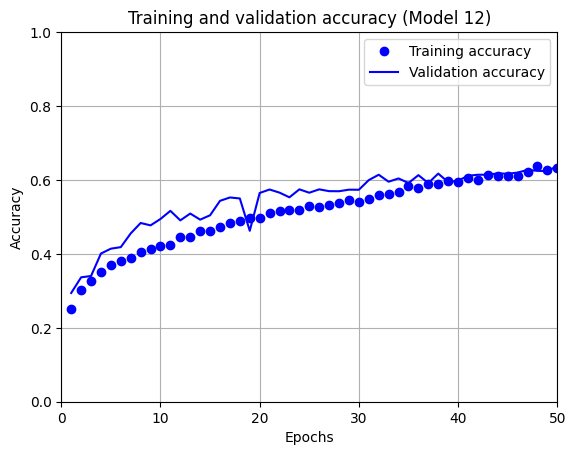

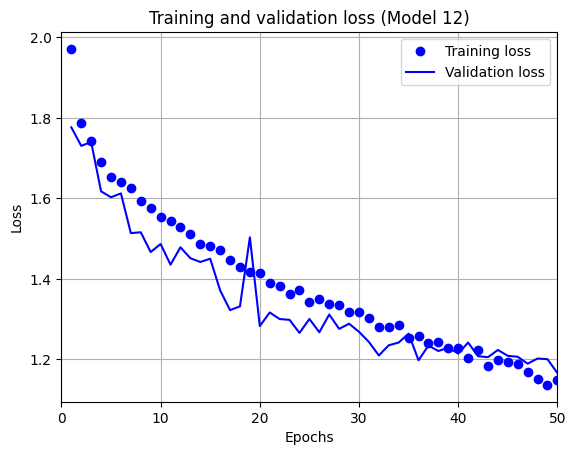

In [7]:
import matplotlib.pyplot as plt

acc12 = result12.history['accuracy']
val_acc12 = result12.history['val_accuracy']
loss12 = result12.history['loss']
val_loss12 = result12.history['val_loss']
epochs12 = range(1, len(acc12) + 1)

# Training and validation accuracy plot
plt.plot(epochs12, acc12, 'bo', label='Training accuracy')
plt.plot(epochs12, val_acc12, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (Model 12)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.ylim(0, 1)   # y축 범위 고정 (0 ~ 1)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()

# Training and validation loss plot
plt.plot(epochs12, loss12, 'bo', label='Training loss')
plt.plot(epochs12, val_loss12, 'b', label='Validation loss')
plt.title('Training and validation loss (Model 12)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, 50)  # x축 범위 고정 (0 ~ 50)
plt.legend()
plt.grid()       # 그리드 추가 (선택 사항)
plt.show()
